In [66]:
import os
import pandas as pd
import numpy as np

In [67]:
data_path = "data/spotify.csv"
try:
    df = pd.read_csv(data_path)
except:
    # Achtung der Pfad "../../../_Daten" muss existieren.
    import kagglehub
    import shutil
    # Download latest version
    path = kagglehub.dataset_download("atharvasoundankar/spotify-global-streaming-data-2024")
    
    # Get the first file in path
    files = os.listdir(path)
    if len(files) == 0:
        raise ValueError("No files found in the downloaded dataset.")
    # Check if the data directory exists, if not create it
    if not os.path.exists("data"):
        os.makedirs("data")

    # Move the downloaded file to the desired directory
    shutil.move(os.path.join(path, files[0]), data_path)

    print("Diabetes dataset downloaded successfully!")

In [68]:
df.head()

,Country,Artist,Album,Genre,Release Year,Monthly Listeners (Millions),Total Streams (Millions),Total Hours Streamed (Millions),Avg Stream Duration (Min),Platform Type,Streams Last 30 Days (Millions),Skip Rate (%)
0,Germany,Taylor Swift,1989 (Taylor's Version),K-pop,2019,23.10,3695.53,14240.35,4.28,Free,118.51,2.24
1,Brazil,The Weeknd,After Hours,R&B,2022,60.60,2828.16,11120.44,3.90,Premium,44.87,23.98
2,United States,Post Malone,Austin,Reggaeton,2023,42.84,1425.46,4177.49,4.03,Free,19.46,4.77
3,Italy,Ed Sheeran,Autumn Variations,K-pop,2018,73.24,2704.33,12024.08,3.26,Premium,166.05,25.12
4,Italy,Ed Sheeran,Autumn Variations,R&B,2023,7.89,3323.25,13446.32,4.47,Free,173.43,15.82


In [69]:
df.keys()

Index(['Country', 'Artist', 'Album', 'Genre', 'Release Year',
       'Monthly Listeners (Millions)', 'Total Streams (Millions)',
       'Total Hours Streamed (Millions)', 'Avg Stream Duration (Min)',
       'Platform Type', 'Streams Last 30 Days (Millions)', 'Skip Rate (%)'],
      dtype='object')

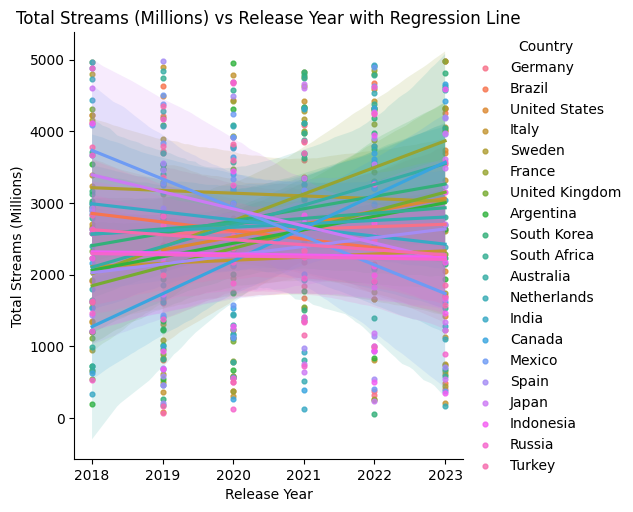

In [70]:
# Drawing a regression line between Release Year and total streams
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

x_name = 'Release Year'
y_name = 'Total Streams (Millions)'
category_name = 'Country'

# Filter the DataFrame to include only the relevant columns
df_filtered = df[[x_name, y_name, category_name]].dropna()

# Convert the Release Year to numeric
df_filtered[x_name] = pd.to_numeric(df_filtered[x_name], errors='coerce')

# Drop rows with NaN values after conversion
df_filtered = df_filtered.dropna()

# Fitting regression model
X = df_filtered[[x_name]].values.reshape(-1, 1)
y = df_filtered[y_name].values.reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
# Plotting the data and the regression line with confidence intervals

sns.lmplot(
    data=df_filtered, 
    x=x_name, 
    y=y_name,
    hue=category_name, 
    ci= 95,
    scatter_kws={'s':12},)
plt.title(f'{y_name} vs {x_name} with Regression Line')
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()